In [8]:
from datetime import datetime, timedelta
import numpy as np
from onc import ONC
import xarray as xr
from xarray.groupers import BinGrouper

# Import common code from the python-community-notebooks repository.
from pcn_common import get_onc_token_from_netrc,format_datetime, convert_scalar_data, split_periods, identify_transit_ports

In [2]:
token = get_onc_token_from_netrc(machine = 'data.oceannetworks.ca')
onc = ONC(token = token)

In [3]:
date_from = datetime(2025,11,3,9,0,0)
date_to = datetime(2025,11,3,20,15,0)

# Download NAV
params = {'locationCode': 'TWDP.N1',
          'deviceCategoryCode': 'NAV',
          'qualityControl': 'clean',
          'dateFrom': format_datetime(date_from),
          'dateTo': format_datetime(date_to),
          'fillGaps': False}
json_response = onc.getScalardata(filters = params, allPages=True)
nav = convert_scalar_data(json_response_data = json_response, out_as = 'xarray')


# Download TSG
params = {'locationCode': 'TWDP',
          'deviceCategoryCode': 'TSG',
          'qualityControl': 'clean',
          'dateFrom': format_datetime(date_from),
          'dateTo': format_datetime(date_to),
          'fillGaps': False}
json_response = onc.getScalardata(filters = params, allPages=True)
tsg = convert_scalar_data(json_response_data=json_response, out_as = 'xarray')

In [4]:
ds = xr.combine_by_coords([nav, tsg], combine_attrs = 'drop_conflicts', join = 'outer')

# Linearly interpolate to nearest position. For simplicity, we do not assume a time-lag.
ds['latitude'] = ds['latitude'].interpolate_na(dim = 'time', method = 'linear', max_gap = timedelta(seconds = 5), fill_value = 'extrapolate')
ds['longitude'] = ds['longitude'].interpolate_na(dim = 'time', method = 'linear', max_gap = timedelta(seconds = 5), fill_value = 'extrapolate')

ds = ds.sel(time = tsg.time)  # Select the original TSG timestamps.
ds = ds[['latitude', 'longitude', 'temperature','practical_salinity']]

In [5]:
transit_times = split_periods(ds.time, min_gap = 60*5)
transits = [ds.sel(time = slice(t['dateFrom'], t['dateTo'])) for t in transit_times]

# Apply median filter with a window size of 13 samples to each transit.
transits = [t.rolling({'time': 13}, center = True, min_periods = 1).median() for t in transits]

In [7]:
example_transit = transits[-1]

In [9]:
def grid_transit(transit: xr.Dataset,
                 lat_min: float = None,
                 lat_max: float = None,
                 lon_min: float = None,
                 lon_max: float = None,
                 bin_size: float = 0.005,
                 central_buffer: float = 0.0025) -> xr.Dataset:

    if lat_min is None:
        lat_min = transit.latitude.min().values - (bin_size * 2)
    if lon_min is None:
        lon_min = transit.longitude.min().values - (bin_size * 2)
    if lat_max is None:
        lat_max = transit.latitude.max().values - (bin_size * 2)
    if lon_max is None:
        lon_max = transit.longitude.max().values - (bin_size * 2)

    transit['ftime'] = transit.time.astype(float)
    lat_grouper = BinGrouper(bins=np.arange(lat_min - central_buffer, lat_max + central_buffer, bin_size))
    lon_grouper = BinGrouper(bins=np.arange(lon_min - central_buffer, lon_max + central_buffer, bin_size))

    bin_lats = lat_grouper.bins[:-1] + central_buffer
    bin_lons = lon_grouper.bins[:-1] + central_buffer

    binned_transit = transit.groupby(latitude=lat_grouper,
                                     longitude=lon_grouper).mean(skipna=True)
    binned_transit['latitude'] = (['latitude_bins'], bin_lats)
    binned_transit['longitude'] = (['longitude_bins'], bin_lons)
    binned_transit = binned_transit.swap_dims({'latitude_bins': 'latitude', 'longitude_bins': 'longitude'})
    binned_transit['time'] = binned_transit.ftime.astype('datetime64[ns]')
    binned_transit = binned_transit.drop_vars(['latitude_bins', 'longitude_bins', 'ftime'], errors='ignore')
    binned_transit = binned_transit.dropna(dim='latitude', how='all')
    binned_transit = binned_transit.dropna(dim='longitude', how='all')

    return binned_transit

In [10]:
binned_example = grid_transit(example_transit)

In [13]:
binned_example

<xarray.Dataset> Size: 132kB
Dimensions:             (latitude: 42, longitude: 130)
Coordinates:
  * latitude            (latitude) float64 336B 49.0 49.01 49.01 ... 49.2 49.21
  * longitude           (longitude) float64 1kB -123.9 -123.9 ... -123.2 -123.2
Data variables:
    temperature         (latitude, longitude) float64 44kB nan nan ... nan nan
    practical_salinity  (latitude, longitude) float64 44kB nan nan ... nan nan
    time                (latitude, longitude) datetime64[ns] 44kB NaT ... NaT
Attributes:
    locationName:  Metadata query input set to minimum. | Not Found
    qaqcFlagInfo:  0:No Quality Control\n1:Data Passed All Tests\n2:Data Prob...

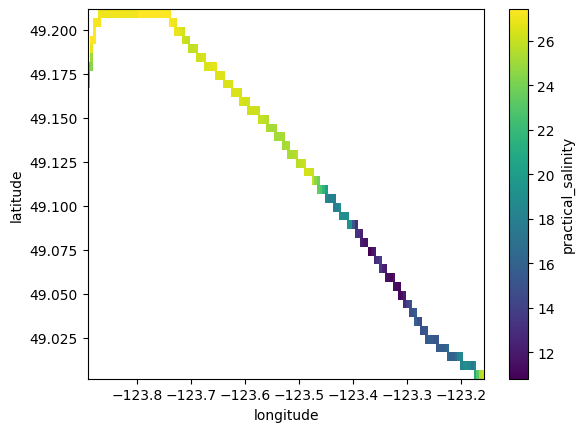

In [12]:
binned_example.practical_salinity.plot()